# Only Take the ws and tp

In [79]:
import xarray as xr
import os

# Directory containing the NetCDF files
input_dir = '/Users/xinyuhu/Documents/Year_4_Summer/Processed_Data_nc'
output_dir = '/Users/xinyuhu/Documents/Year_4_Summer/ws_tp_only_nc_1'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all NetCDF files in the input directory
files = [f for f in os.listdir(input_dir) if f.endswith('.nc')]

for file in files:
    file_path = os.path.join(input_dir, file)
    
    # Open the NetCDF file
    ds = xr.open_dataset(file_path)
    
    # Select only the 'ws10' and 'tp' variables
    ds_selected = ds[['ws10', 'tp']]
    
    # Define the output file path
    output_file_path = os.path.join(output_dir, file)
    
    # Save the selected data to a new NetCDF file
    ds_selected.to_netcdf(output_file_path)
    
    print(f"Processed and saved: {file}")

print("All files processed.")


Processed and saved: UNAMED_1949_09.nc
Processed and saved: UNAMED_1949_08.nc
All files processed.


# Uncontinuous Filter： set strict threshold to filter the data

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the NetCDF file
file_path = 'ws_tp_only_nc/ABBY_1968_07.nc'
ds = xr.open_dataset(file_path)

# Calculate the 90% quantile for 'ws10' and 'tp'
ws10_95_quantile = ds['ws10'].quantile(0.95).item()
tp_95_quantile = ds['tp'].quantile(0.95).item()

# Print the thresholds
print(f"95% quantile for ws10: {ws10_95_quantile}")
print(f"95% quantile for tp: {tp_95_quantile}")


95% quantile for ws10: 2.902651071548462
95% quantile for tp: 0.0009270299078189105


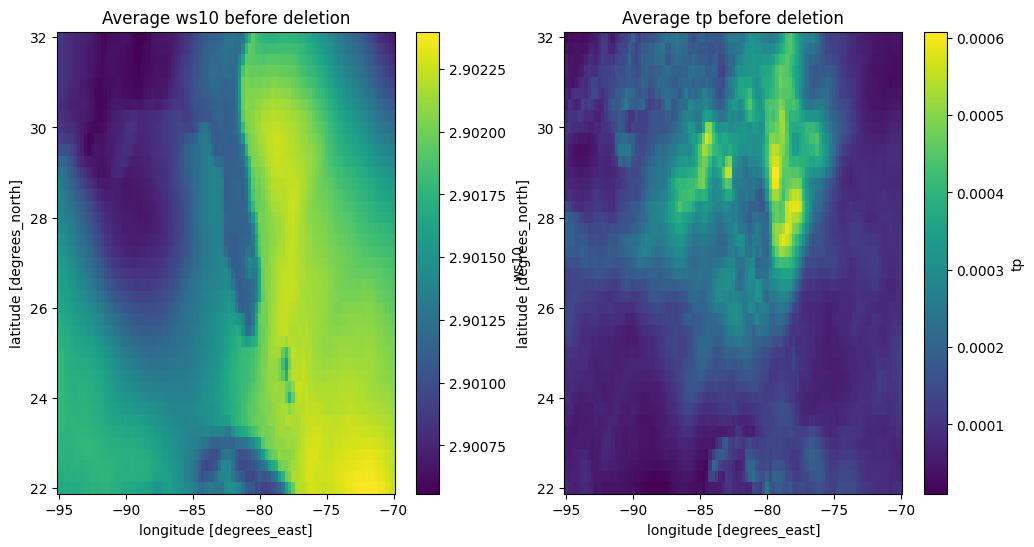

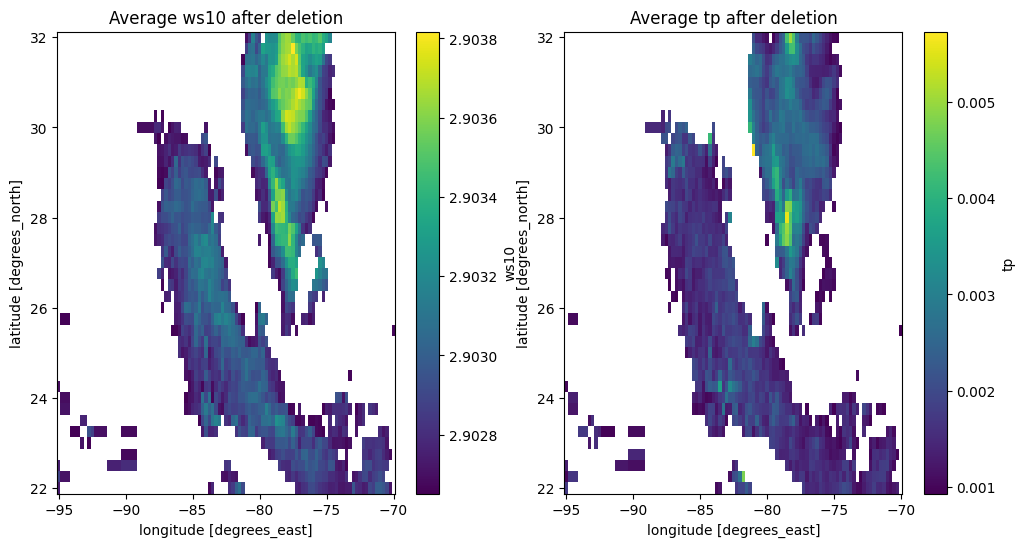

In [37]:

# Identify locations where either variables are below the thresholds
mask_ws10 = ds['ws10'] < ws10_95_quantile
mask_tp = ds['tp'] < tp_95_quantile
combined_mask = mask_ws10 | mask_tp

# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
ds['ws10'].mean(dim='time').plot()
plt.title('Average ws10 before deletion')

plt.subplot(122)
ds['tp'].mean(dim='time').plot()
plt.title('Average tp before deletion')
plt.show()

# Apply the mask and remove data from locations below thresholds
ds_filtered = ds.where(~combined_mask, drop=True)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
ds_filtered['ws10'].mean(dim='time').plot()
plt.title('Average ws10 after deletion')

plt.subplot(122)
ds_filtered['tp'].mean(dim='time').plot()
plt.title('Average tp after deletion')
plt.show()


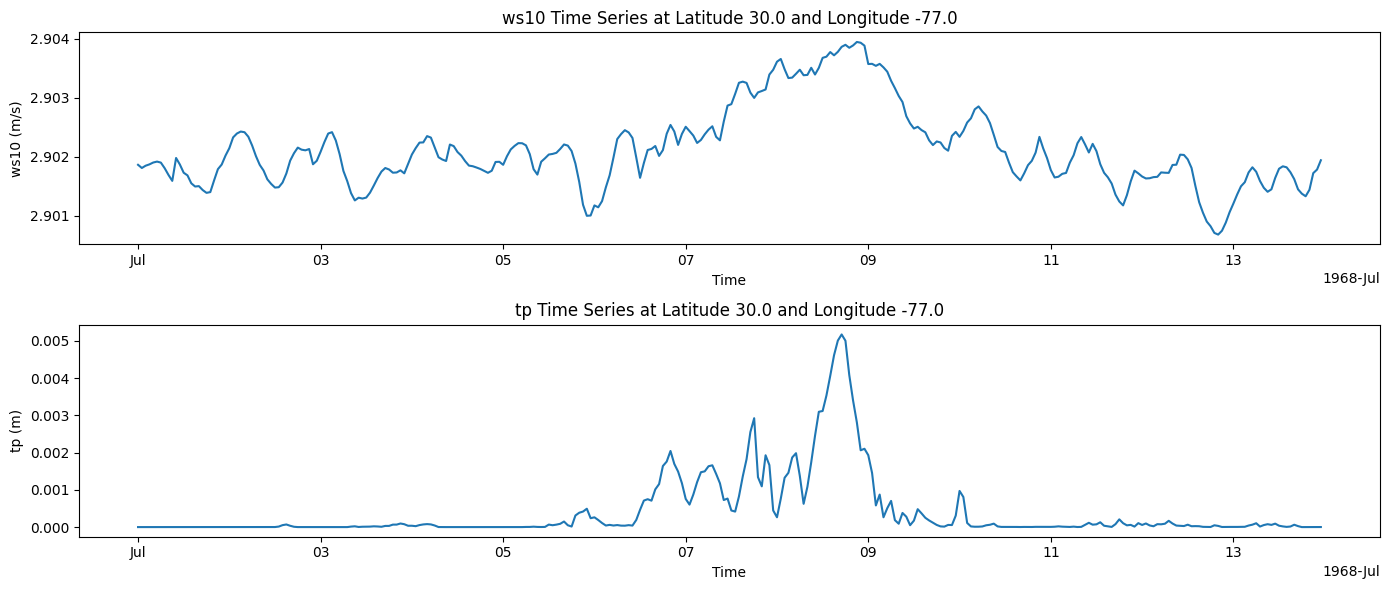

In [1]:
import xarray as xr
import matplotlib.pyplot as plt


ds = xr.open_dataset('ws_tp_only_nc/ABBY_1968_07.nc')

# Define the specific location (adjust these values as needed)
specific_latitude = 30  # example latitude
specific_longitude = -77  # example longitude

# Find the nearest grid point to the specified location
lat_idx = ds.sel(latitude=specific_latitude, method='nearest').latitude.item()
lon_idx = ds.sel(longitude=specific_longitude, method='nearest').longitude.item()

# Extract the time series data for the specific location
ws10_timeseries = ds['ws10'].sel(latitude=lat_idx, longitude=lon_idx)
tp_timeseries = ds['tp'].sel(latitude=lat_idx, longitude=lon_idx)

# Plot the time series for ws10 and tp
plt.figure(figsize=(14, 6))

plt.subplot(211)
ws10_timeseries.plot()
plt.title(f'ws10 Time Series at Latitude {lat_idx} and Longitude {lon_idx}')
plt.xlabel('Time')
plt.ylabel('ws10 (m/s)')

plt.subplot(212)
tp_timeseries.plot()
plt.title(f'tp Time Series at Latitude {lat_idx} and Longitude {lon_idx}')
plt.xlabel('Time')
plt.ylabel('tp (m)')

plt.tight_layout()
plt.show()


# Spatial Corr with common time

ws10_threshold: 2.901994466781616
tp_threshold: 6.298747235931618e-05
Filtered dataset size: (13, 41, 101)
ws10_timeseries length: 4
tp_timeseries length: 4


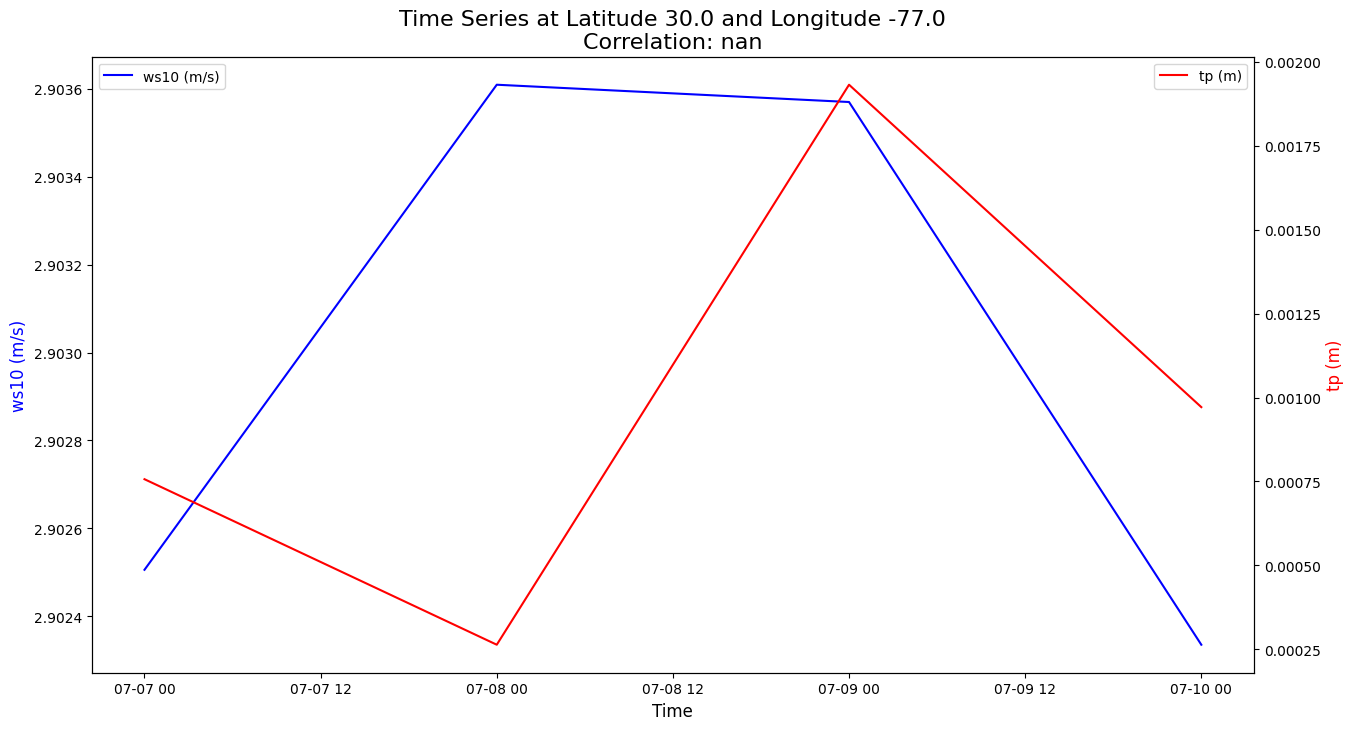

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_quantiles(ds, quantile=0.9):
    ws10_90_quantile = ds['ws10'].quantile(quantile).item()
    tp_90_quantile = ds['tp'].quantile(quantile).item()
    return ws10_90_quantile, tp_90_quantile

def filter_extreme_events(ds, ws10_threshold, tp_threshold):
    extreme_ws10 = ds['ws10'] >= ws10_threshold
    extreme_tp = ds['tp'] >= tp_threshold
    extreme_periods = extreme_ws10 & extreme_tp
    ds_extreme = ds.where(extreme_periods, drop=True)
    
    common_time = pd.date_range(start=ds.time.min().values, end=ds.time.max().values, freq='D')
    ds_extreme_reindexed = ds_extreme.reindex(time=common_time, method='nearest')
    
    return ds_extreme_reindexed

def plot_temporal_correlation(ds, location, title):
    # Extract time series at the specific location
    ws10_timeseries = ds['ws10'].sel(latitude=location['latitude'], longitude=location['longitude'], method='nearest')
    tp_timeseries = ds['tp'].sel(latitude=location['latitude'], longitude=location['longitude'], method='nearest')

    print(f"ws10_timeseries length: {len(ws10_timeseries.dropna('time'))}")
    print(f"tp_timeseries length: {len(tp_timeseries.dropna('time'))}")

    # Check if there are no data points
    if len(ws10_timeseries.dropna('time')) == 0 or len(tp_timeseries.dropna('time')) == 0:
        print("No data points available after filtering.")
        return

    # Calculate temporal correlation
    correlation = np.corrcoef(ws10_timeseries, tp_timeseries)[0, 1]

    # Plot time series
    fig, ax1 = plt.subplots(figsize=(15, 8))

    ax1.set_title(f'Time Series at Latitude {location["latitude"]} and Longitude {location["longitude"]}\nCorrelation: {correlation:.2f}', fontsize=16)
    ax1.plot(ws10_timeseries['time'], ws10_timeseries, 'b-', label='ws10 (m/s)')
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('ws10 (m/s)', color='b', fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(tp_timeseries['time'], tp_timeseries, 'r-', label='tp (m)')
    ax2.set_ylabel('tp (m)', color='r', fontsize=12)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

def process_single_file(input_file, location, quantile=0.9):
    ds = xr.open_dataset(input_file)
    
    ws10_threshold, tp_threshold = calculate_quantiles(ds, quantile)
    
    print(f"ws10_threshold: {ws10_threshold}")
    print(f"tp_threshold: {tp_threshold}")

    ds_filtered = filter_extreme_events(ds, ws10_threshold, tp_threshold)
    
    print(f"Filtered dataset size: {ds_filtered['ws10'].shape}")

    plot_temporal_correlation(ds_filtered, location, input_file)

# Example usage
input_file = 'ws_tp_only_nc/ABBY_1968_07.nc'
location = {'latitude': 30.0, 'longitude': -77.0}  # Example coordinates

process_single_file(input_file, location, quantile=0.7)


MovieWriter imagemagick unavailable; using Pillow instead.


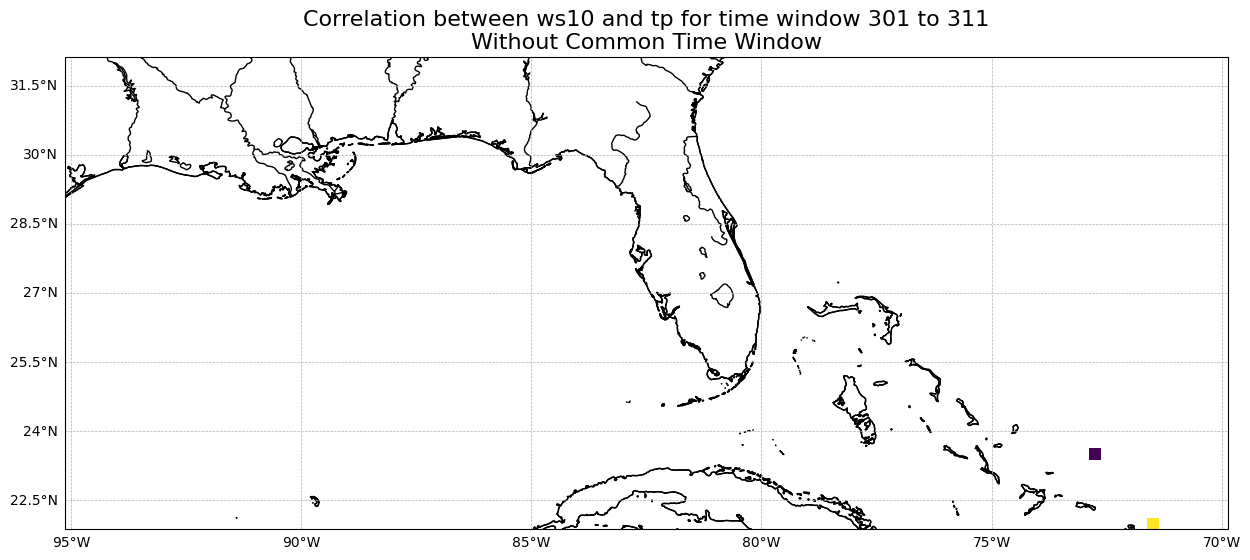

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.animation as animation

def animate_correlations(ds, title, output_file):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    def update(frame):
        ax.clear()
        time_window = ds.isel(time=slice(frame, frame + window_size))
        correlations = xr.corr(time_window['ws10'], time_window['tp'], dim='time')
        
        im = correlations.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap = 'viridis') # , cmap='coolwarm'
        
        # Add map features without colors
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.RIVERS, edgecolor='black')

        gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        
        ax.set_title(f'Correlation between ws10 and tp for time window {frame} to {frame + window_size}\n{title}', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        
        return im
    
    window_size = 10  # Define the size of the time window
    ani = animation.FuncAnimation(fig, update, frames=range(len(ds['time']) - window_size), repeat=False)
    ani.save(output_file, writer='imagemagick', fps=2)
    plt.show()

# Example usage for animation
file_path = '95_ws_tp_only_nc_or/ABBY_1968_07.nc'
output_file = 'correlation_animation1.gif'
ds = xr.open_dataset(file_path)
animate_correlations(ds, 'Without Common Time Window', output_file)


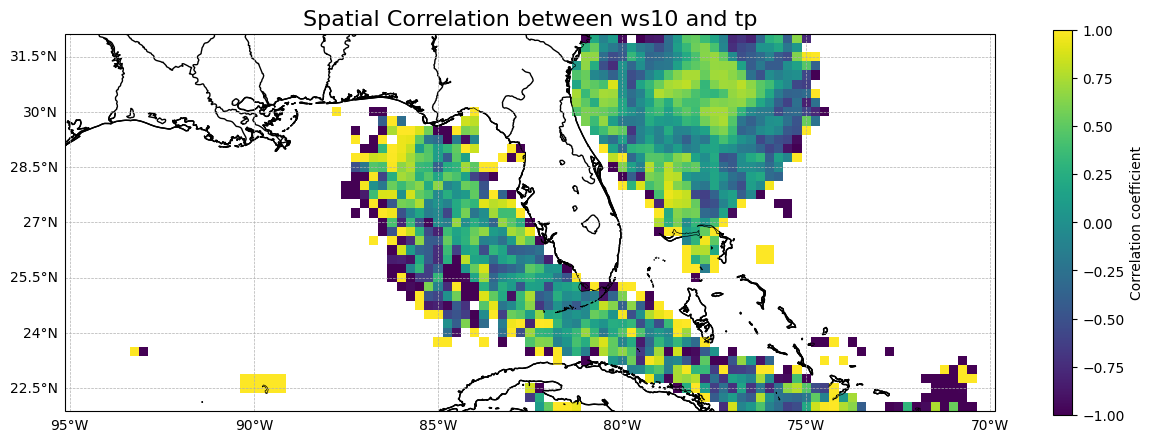

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def plot_stored_spatial_correlation(file_path):
    # Load the NetCDF file
    ds = xr.open_dataset(file_path)
    
    # Ensure the spatial_correlation variable exists
    if 'spatial_correlation' not in ds:
        print("Error: 'spatial_correlation' variable not found in the dataset.")
        return
    
    spatial_correlation = ds['spatial_correlation']
    
    # Plot the spatial correlation
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    spatial_correlation.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cbar_kwargs={'label': 'Correlation coefficient', 'shrink': 0.5}, # Adjust the shrink parameter to reduce the size of the color bar
        cmap='viridis' # , cmap='coolwarm'
    )
    
    # Add map features without colors
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    plt.title('Spatial Correlation between ws10 and tp', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    
    plt.show()

# Example usage
file_path = '95_ws_tp_only_nc_or/ABBY_1968_07.nc'
plot_stored_spatial_correlation(file_path)


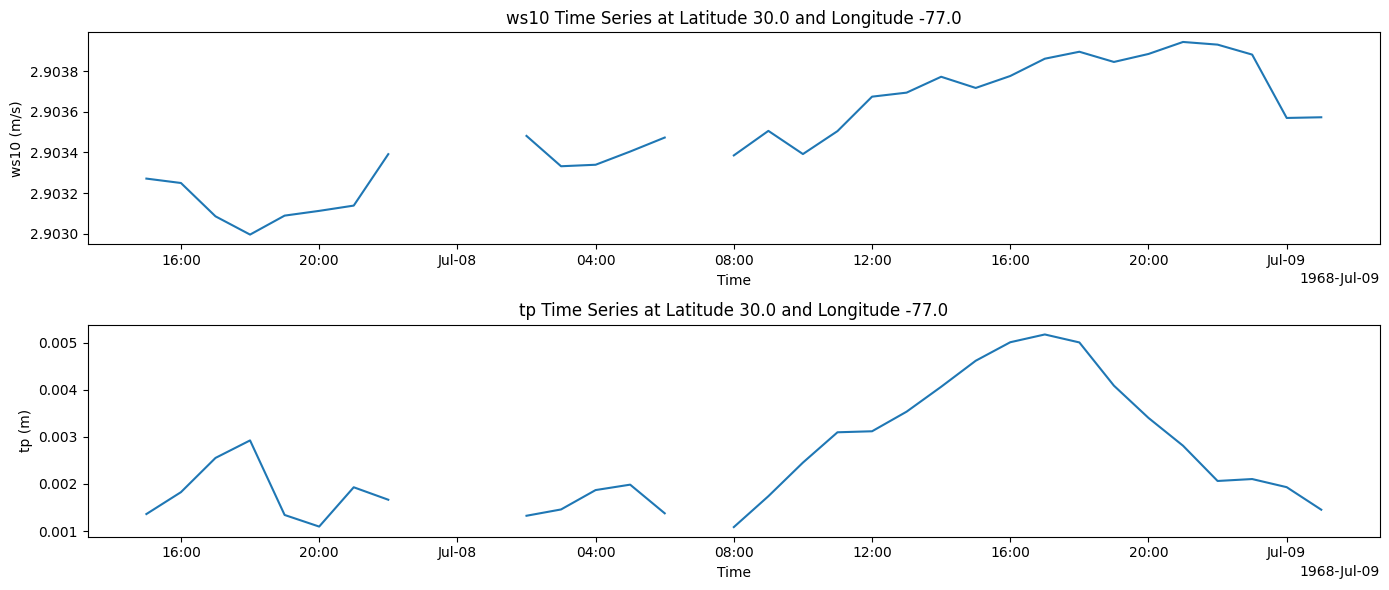

In [8]:
import xarray as xr
import matplotlib.pyplot as plt


ds = xr.open_dataset('95_ws_tp_only_nc_or/ABBY_1968_07.nc')

# Define the specific location (adjust these values as needed)
specific_latitude = 30  # example latitude
specific_longitude = -77  # example longitude

# Find the nearest grid point to the specified location
lat_idx = ds.sel(latitude=specific_latitude, method='nearest').latitude.item()
lon_idx = ds.sel(longitude=specific_longitude, method='nearest').longitude.item()

# Extract the time series data for the specific location
ws10_timeseries = ds['ws10'].sel(latitude=lat_idx, longitude=lon_idx)
tp_timeseries = ds['tp'].sel(latitude=lat_idx, longitude=lon_idx)

# Plot the time series for ws10 and tp
plt.figure(figsize=(14, 6))

plt.subplot(211)
ws10_timeseries.plot()
plt.title(f'ws10 Time Series at Latitude {lat_idx} and Longitude {lon_idx}')
plt.xlabel('Time')
plt.ylabel('ws10 (m/s)')

plt.subplot(212)
tp_timeseries.plot()
plt.title(f'tp Time Series at Latitude {lat_idx} and Longitude {lon_idx}')
plt.xlabel('Time')
plt.ylabel('tp (m)')

plt.tight_layout()
plt.show()


# Continuous Filter:  Find the first and last index of the time when data = threshold.

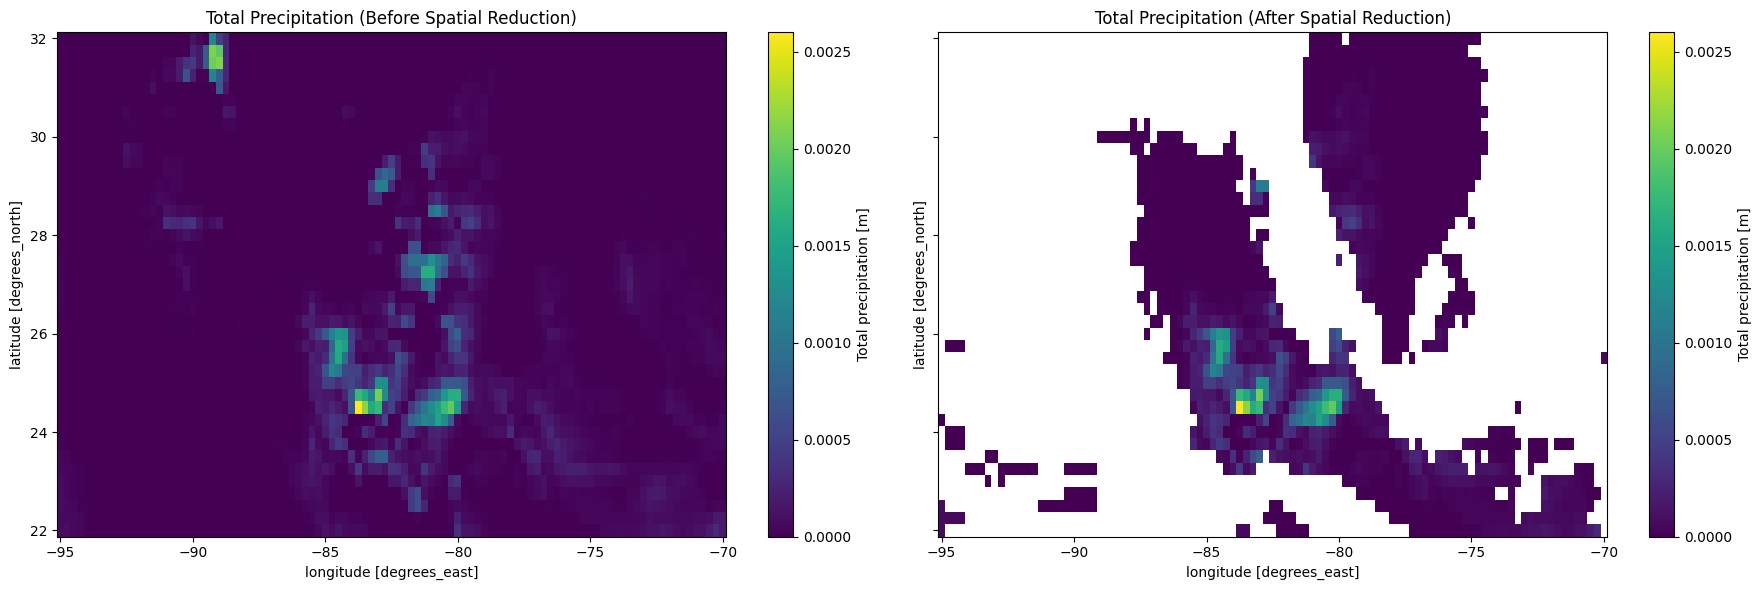

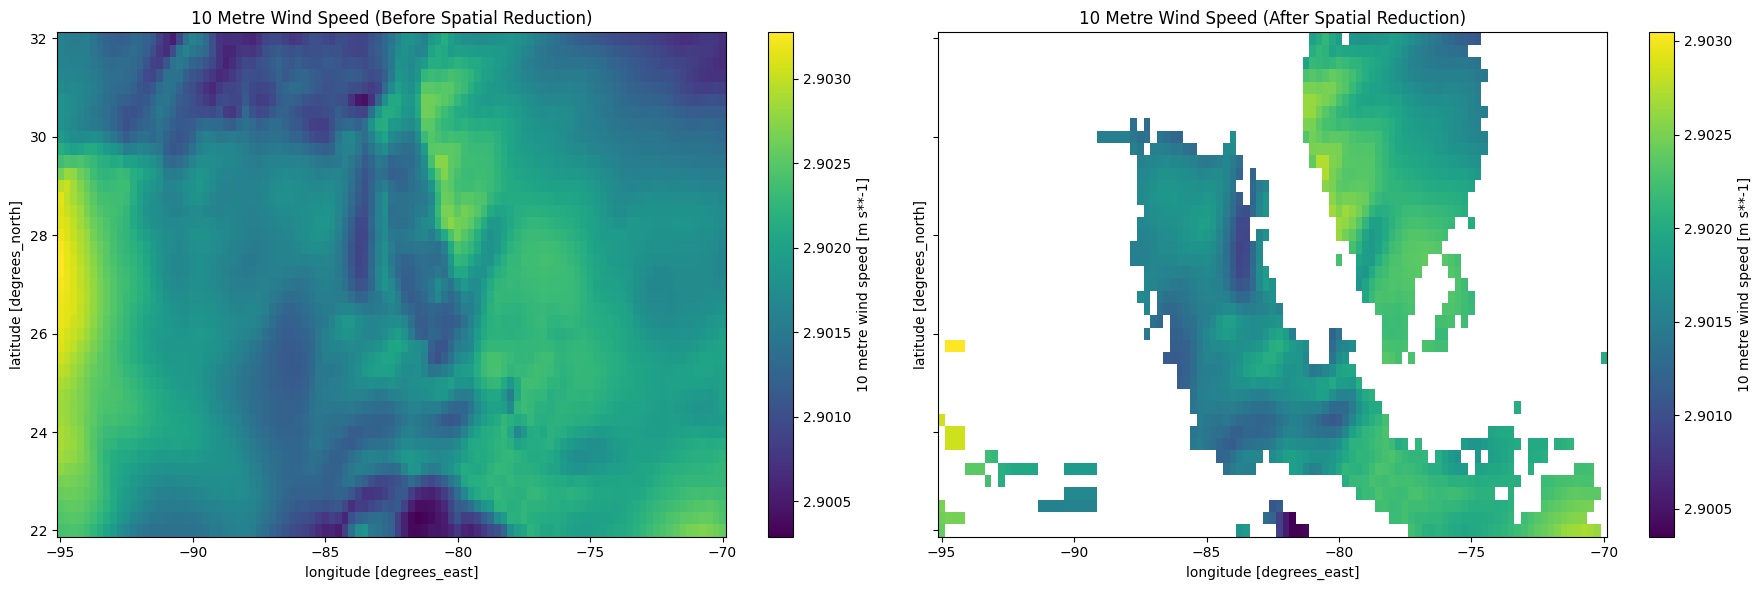

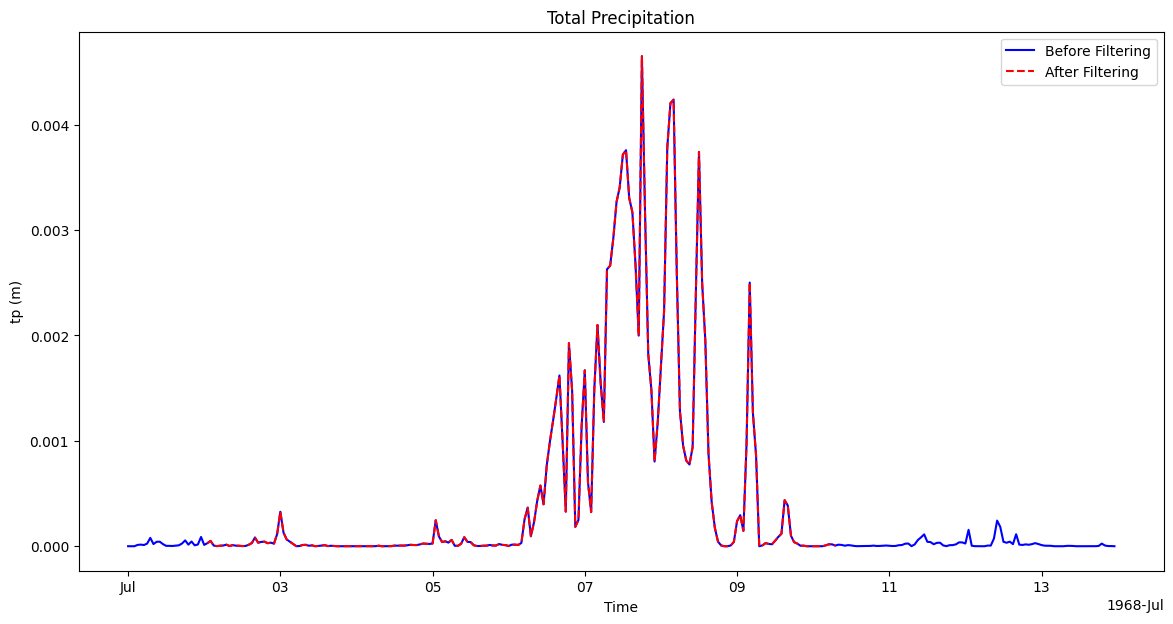

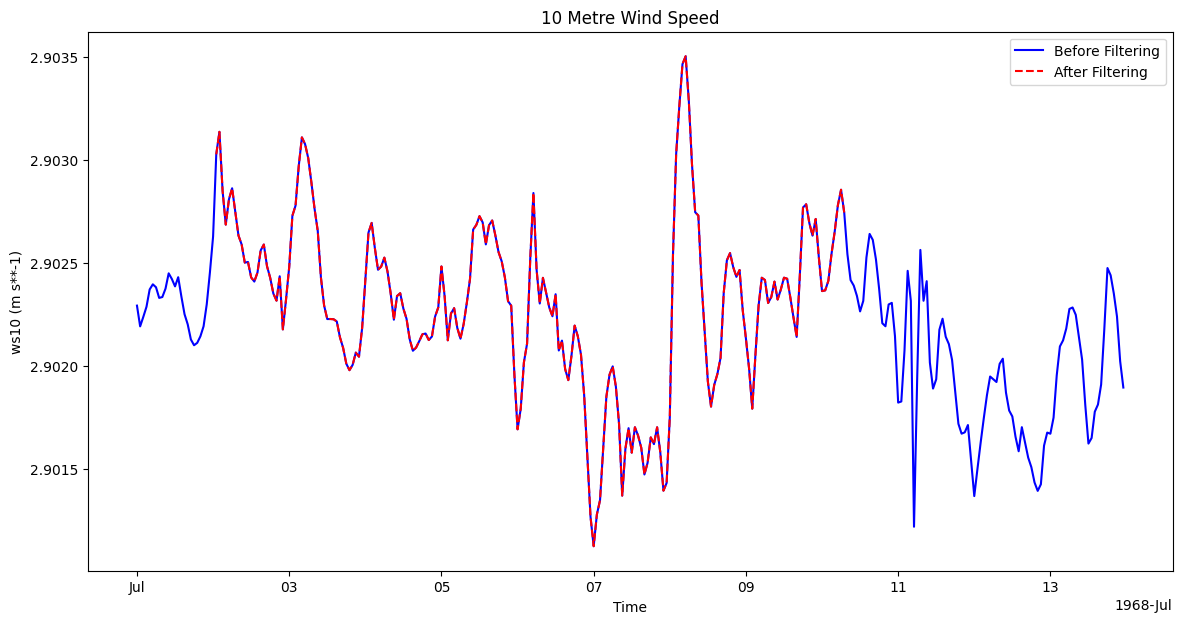

Spatial and temporal filtering complete.


In [16]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Define the file to process
file_path = 'ws_tp_only_nc/ABBY_1968_07.nc'

# Open the dataset
ds = xr.open_dataset(file_path)

# Function to calculate the 95th percentile threshold
def get_threshold(data_array):
    threshold = np.percentile(data_array, 95)
    return threshold

# Calculate thresholds for both variables
tp_threshold = get_threshold(ds['tp'])
ws10_threshold = get_threshold(ds['ws10'])

# Create masks for values above the thresholds
tp_mask = ds['tp'] >= tp_threshold
ws10_mask = ds['ws10'] >= ws10_threshold

# Spatial filtering: Retain only locations where both variables are above the threshold at any time
location_mask = (tp_mask & ws10_mask).any(dim='time')

# Apply spatial filtering
ds_filtered_spatial = ds.where(location_mask, drop=True)

# Temporal filtering: Retain periods around extreme values
def filter_temporal(data_array, tp_mask, ws10_mask):
    combined_mask = tp_mask | ws10_mask
    
    time_dim = data_array.dims[0]
    lat_dim = data_array.dims[1]
    lon_dim = data_array.dims[2]

    time_mask = np.zeros_like(combined_mask, dtype=bool)
    
    for lat in range(combined_mask.shape[1]):
        for lon in range(combined_mask.shape[2]):
            first_idx = combined_mask[:, lat, lon].argmax().item()
            last_idx = len(combined_mask[:, lat, lon]) - combined_mask[:, lat, lon][::-1].argmax().item()
            time_mask[first_idx:last_idx, lat, lon] = True

    temporal_mask = xr.DataArray(time_mask, dims=[time_dim, lat_dim, lon_dim], coords=data_array.coords)
    return data_array.where(temporal_mask, drop=True)

# Apply temporal filtering
tp_filtered_temporal = filter_temporal(ds_filtered_spatial['tp'], tp_mask.sel(latitude=ds_filtered_spatial.latitude, longitude=ds_filtered_spatial.longitude), ws10_mask.sel(latitude=ds_filtered_spatial.latitude, longitude=ds_filtered_spatial.longitude))
ws10_filtered_temporal = filter_temporal(ds_filtered_spatial['ws10'], tp_mask.sel(latitude=ds_filtered_spatial.latitude, longitude=ds_filtered_spatial.longitude), ws10_mask.sel(latitude=ds_filtered_spatial.latitude, longitude=ds_filtered_spatial.longitude))

# Combine the filtered datasets
ds_filtered_temporal = xr.Dataset({
    'tp': tp_filtered_temporal,
    'ws10': ws10_filtered_temporal
})

# Define a specific location (latitude and longitude indices) for plotting
latitude_index = 20  # Example index, adjust as needed
longitude_index = 50  # Example index, adjust as needed

# Plotting function for time series
def plot_time_series(variable, title, dataset_before, dataset_after, lat_idx, lon_idx):
    data_before = dataset_before[variable].isel(latitude=lat_idx, longitude=lon_idx)
    data_after = dataset_after[variable].isel(latitude=lat_idx, longitude=lon_idx)
    
    plt.figure(figsize=(14, 7))
    data_before.plot(label='Before Filtering', linestyle='-', color='blue')
    data_after.plot(label='After Filtering', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(f"{variable} ({data_before.attrs['units']})")
    plt.legend()
    plt.show()

# Plotting function for spatial data
def plot_spatial(variable, title, dataset_before, dataset_after, time_index=0):
    data_before = dataset_before[variable].isel(time=time_index)
    data_after = dataset_after[variable].isel(time=time_index)
    
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
    
    data_before.plot(ax=axs[0])
    axs[0].set_title(f'{title} (Before Spatial Reduction)')
    
    data_after.plot(ax=axs[1])
    axs[1].set_title(f'{title} (After Spatial Reduction)')
    
    plt.tight_layout()
    plt.show()

# Define a specific time index for plotting
time_index = 0  # Adjust as needed

# Plot spatial data before and after filtering
plot_spatial('tp', 'Total Precipitation', ds, ds_filtered_spatial, time_index)
plot_spatial('ws10', '10 Metre Wind Speed', ds, ds_filtered_spatial, time_index)

# Plot time series before and after filtering
plot_time_series('tp', 'Total Precipitation', ds_filtered_spatial, ds_filtered_temporal, latitude_index, longitude_index)
plot_time_series('ws10', '10 Metre Wind Speed', ds_filtered_spatial, ds_filtered_temporal, latitude_index, longitude_index)

print("Spatial and temporal filtering complete.")

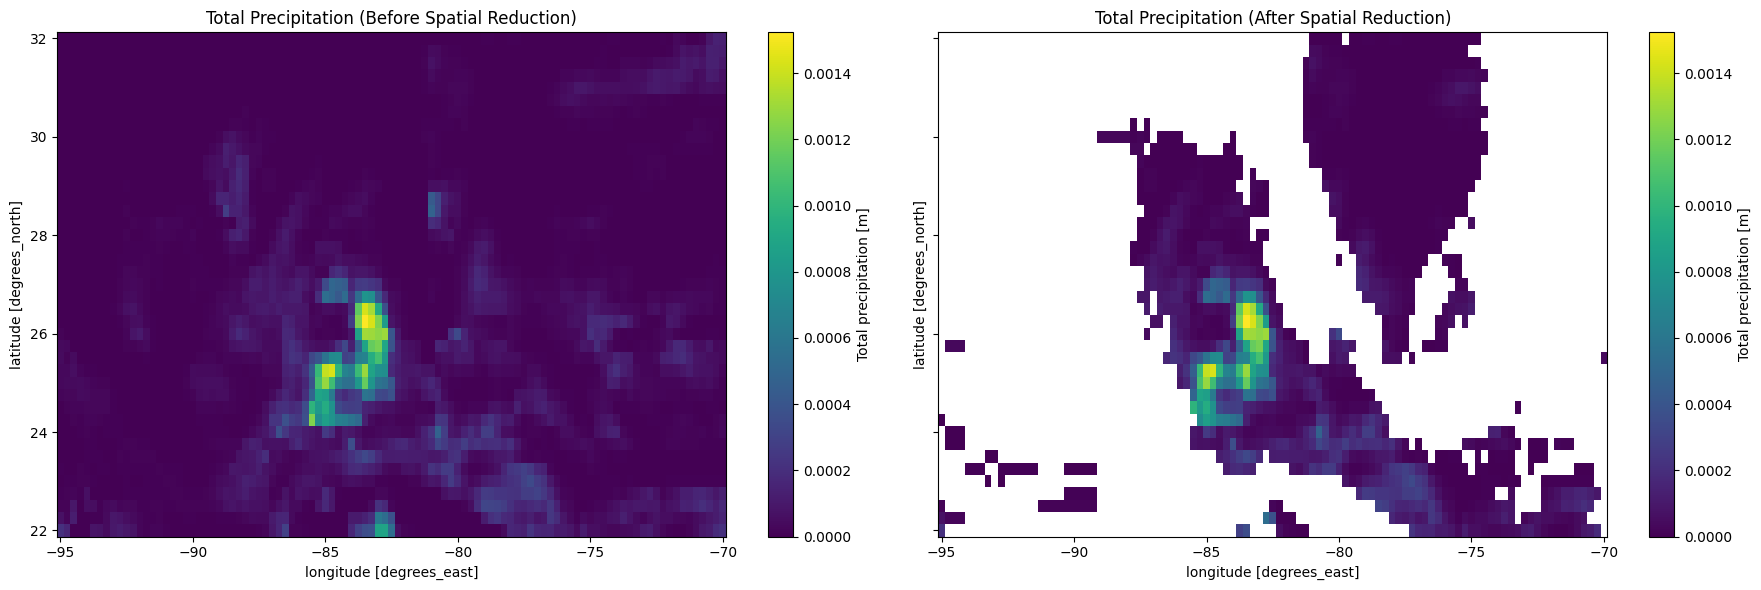

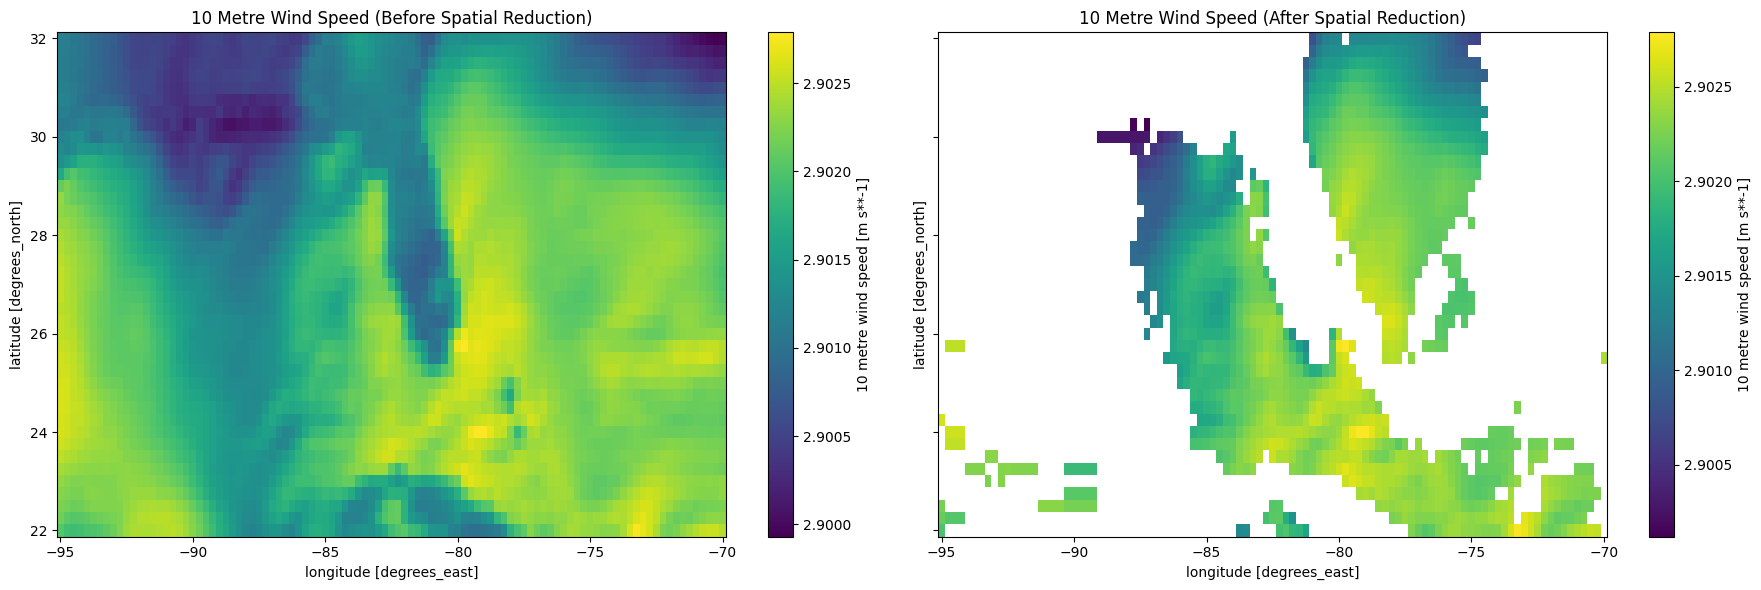

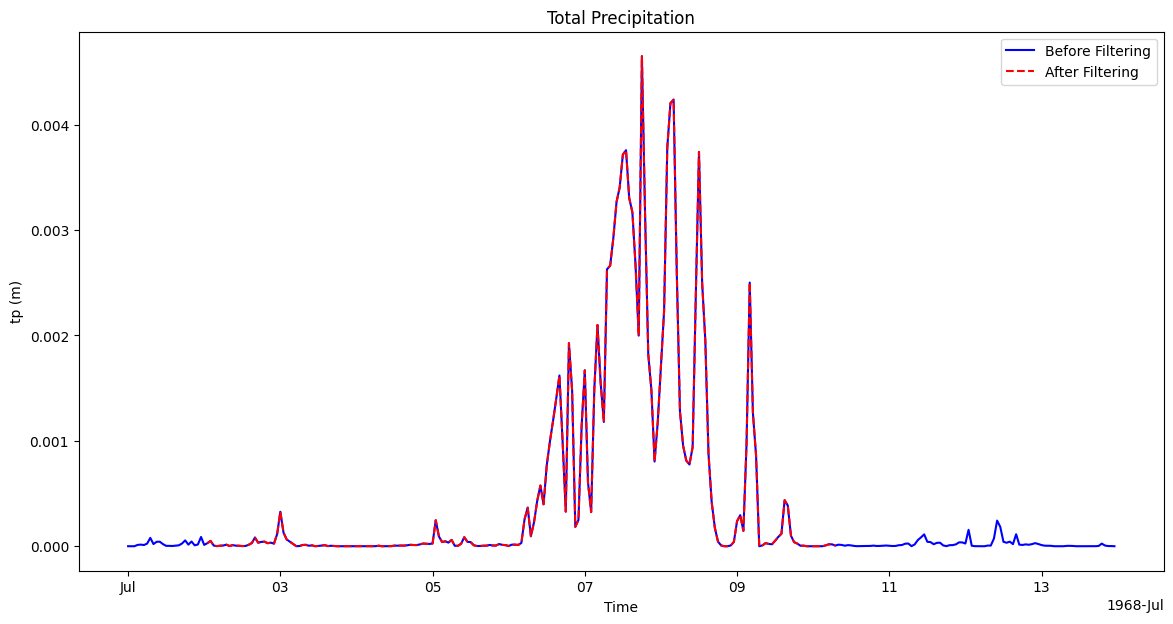

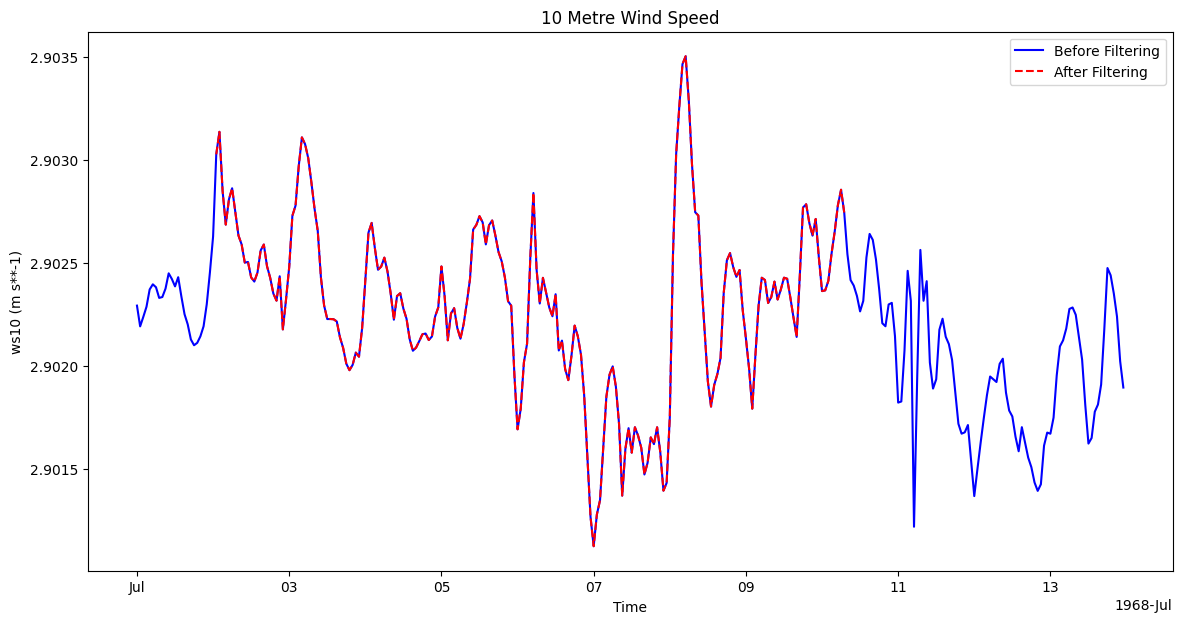

Spatial and temporal filtering complete.


In [17]:
# Define a specific time index for plotting
time_index = 10  # Adjust as needed

# Plot spatial data before and after filtering
plot_spatial('tp', 'Total Precipitation', ds, ds_filtered_spatial, time_index)
plot_spatial('ws10', '10 Metre Wind Speed', ds, ds_filtered_spatial, time_index)

# Plot time series before and after filtering
plot_time_series('tp', 'Total Precipitation', ds_filtered_spatial, ds_filtered_temporal, latitude_index, longitude_index)
plot_time_series('ws10', '10 Metre Wind Speed', ds_filtered_spatial, ds_filtered_temporal, latitude_index, longitude_index)

print("Spatial and temporal filtering complete.")

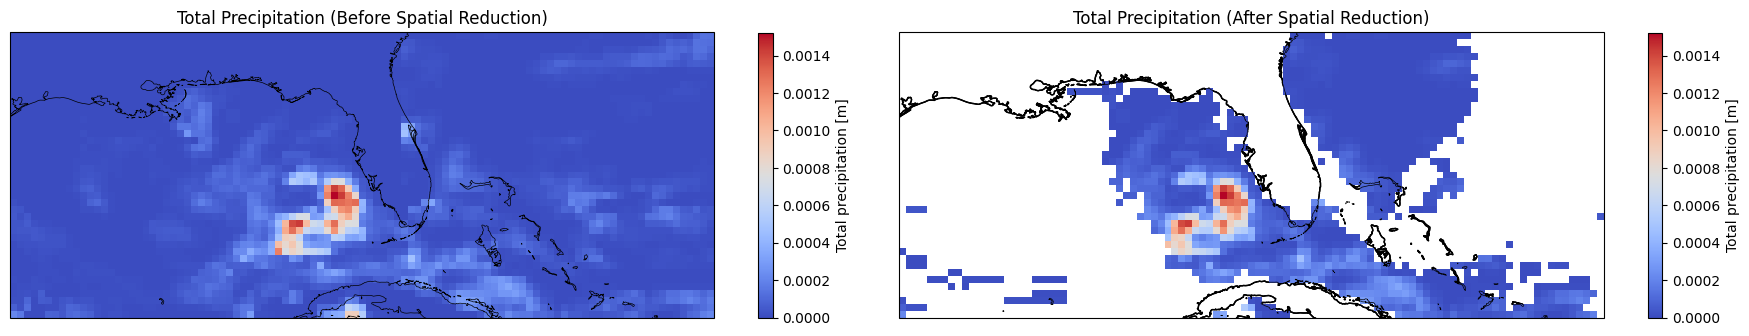

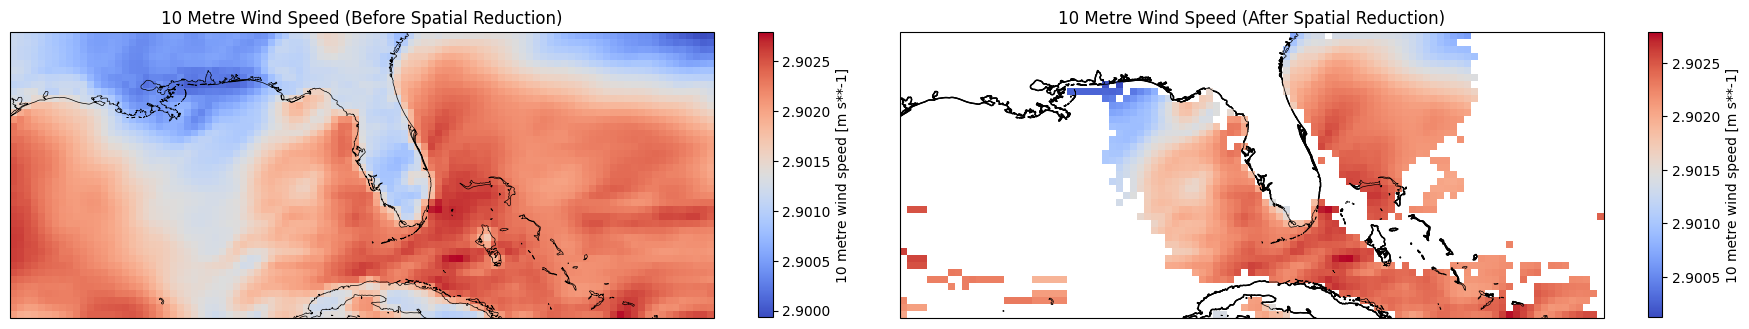

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_spatial(variable, title, dataset_before, dataset_after, time_index=0):
    # Extract the data for the specific time index
    data_before = dataset_before[variable].isel(time=time_index)
    data_after = dataset_after[variable].isel(time=time_index)
    
    # Set up the plot with cartopy projections
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True, sharey=True)
    
    # Plotting the data before spatial reduction
    data_before.plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap='coolwarm', 
                     add_colorbar=True, cbar_kwargs={'shrink': 0.5})
    axs[0].set_title(f'{title} (Before Spatial Reduction)')
    # Add map features to the first subplot
    axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
    axs[0].add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
    axs[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    axs[0].add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
    
    # Plotting the data after spatial reduction
    data_after.plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap='coolwarm', 
                    add_colorbar=True, cbar_kwargs={'shrink': 0.5})
    axs[1].set_title(f'{title} (After Spatial Reduction)')
    # Add map features to the second subplot
    axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
    axs[1].add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
    axs[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    axs[1].add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
    
    plt.tight_layout()
    plt.show()

time_index = 10  # Adjust as needed

# Plot spatial data before and after filtering
plot_spatial('tp', 'Total Precipitation', ds, ds_filtered_spatial, time_index)
plot_spatial('ws10', '10 Metre Wind Speed', ds, ds_filtered_spatial, time_index)

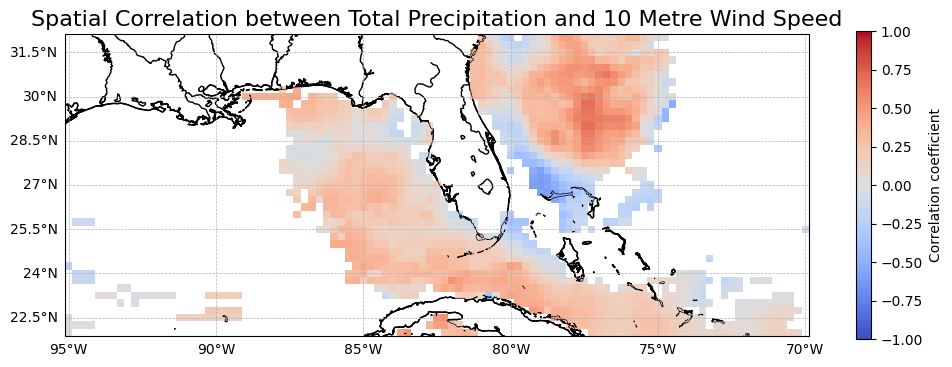

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr

def calculate_spatial_correlation(ds):
    tp = ds['tp']
    ws10 = ds['ws10']
    
    correlation = xr.corr(tp, ws10, dim='time')
    return correlation

spatial_correlation = calculate_spatial_correlation(ds_filtered_temporal)

# Plot spatial correlation with map and improved quality
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
im = spatial_correlation.plot(ax=ax, transform=ccrs.PlateCarree(),
        cbar_kwargs={'label': 'Correlation coefficient', 'shrink': 0.5},cmap='coolwarm', vmin=-1, vmax=1)

# Add map features without colors
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

# Gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Title and labels
plt.title('Spatial Correlation between Total Precipitation and 10 Metre Wind Speed', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Colorbar
# cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, fraction=0.05)
# cbar.set_label('Correlation', fontsize=12)

plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


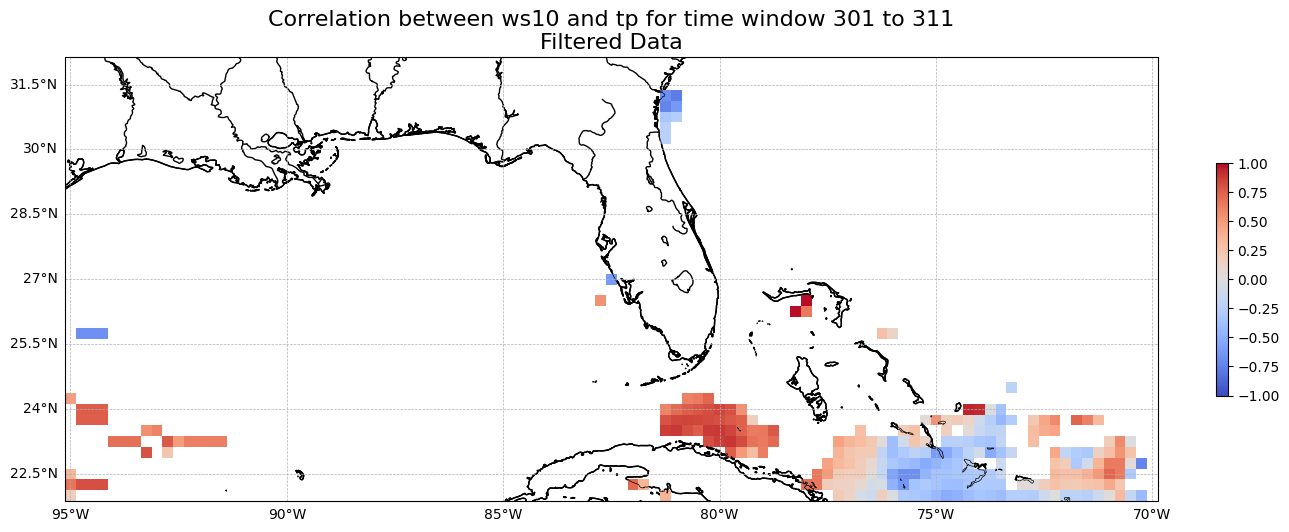

In [12]:
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.animation as animation


# Function to create an animation of the correlations
def animate_correlations(ds, title, output_file):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    window_size = 10  # Define the size of the time window

    def update(frame):
        ax.clear()
        time_window = ds.isel(time=slice(frame, frame + window_size))
        correlations = xr.corr(time_window['ws10'], time_window['tp'], dim='time')
        
        im = correlations.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='coolwarm', vmin=-1, vmax=1)
        
        # Add map features without colors
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.RIVERS, edgecolor='black')

        gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        
        ax.set_title(f'Correlation between ws10 and tp for time window {frame} to {frame + window_size}\n{title}', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        
        return im
    
    ani = animation.FuncAnimation(fig, update, frames=range(len(ds['time']) - window_size), repeat=False)
    fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-1, vmax=1)), ax=ax, pad=0.05, fraction=0.01)
    ani.save(output_file, writer='imagemagick', fps=2)
    plt.show()

# Run the animation
animate_correlations(ds_filtered_temporal, 'Filtered Data', 'temporal_correlation.gif')

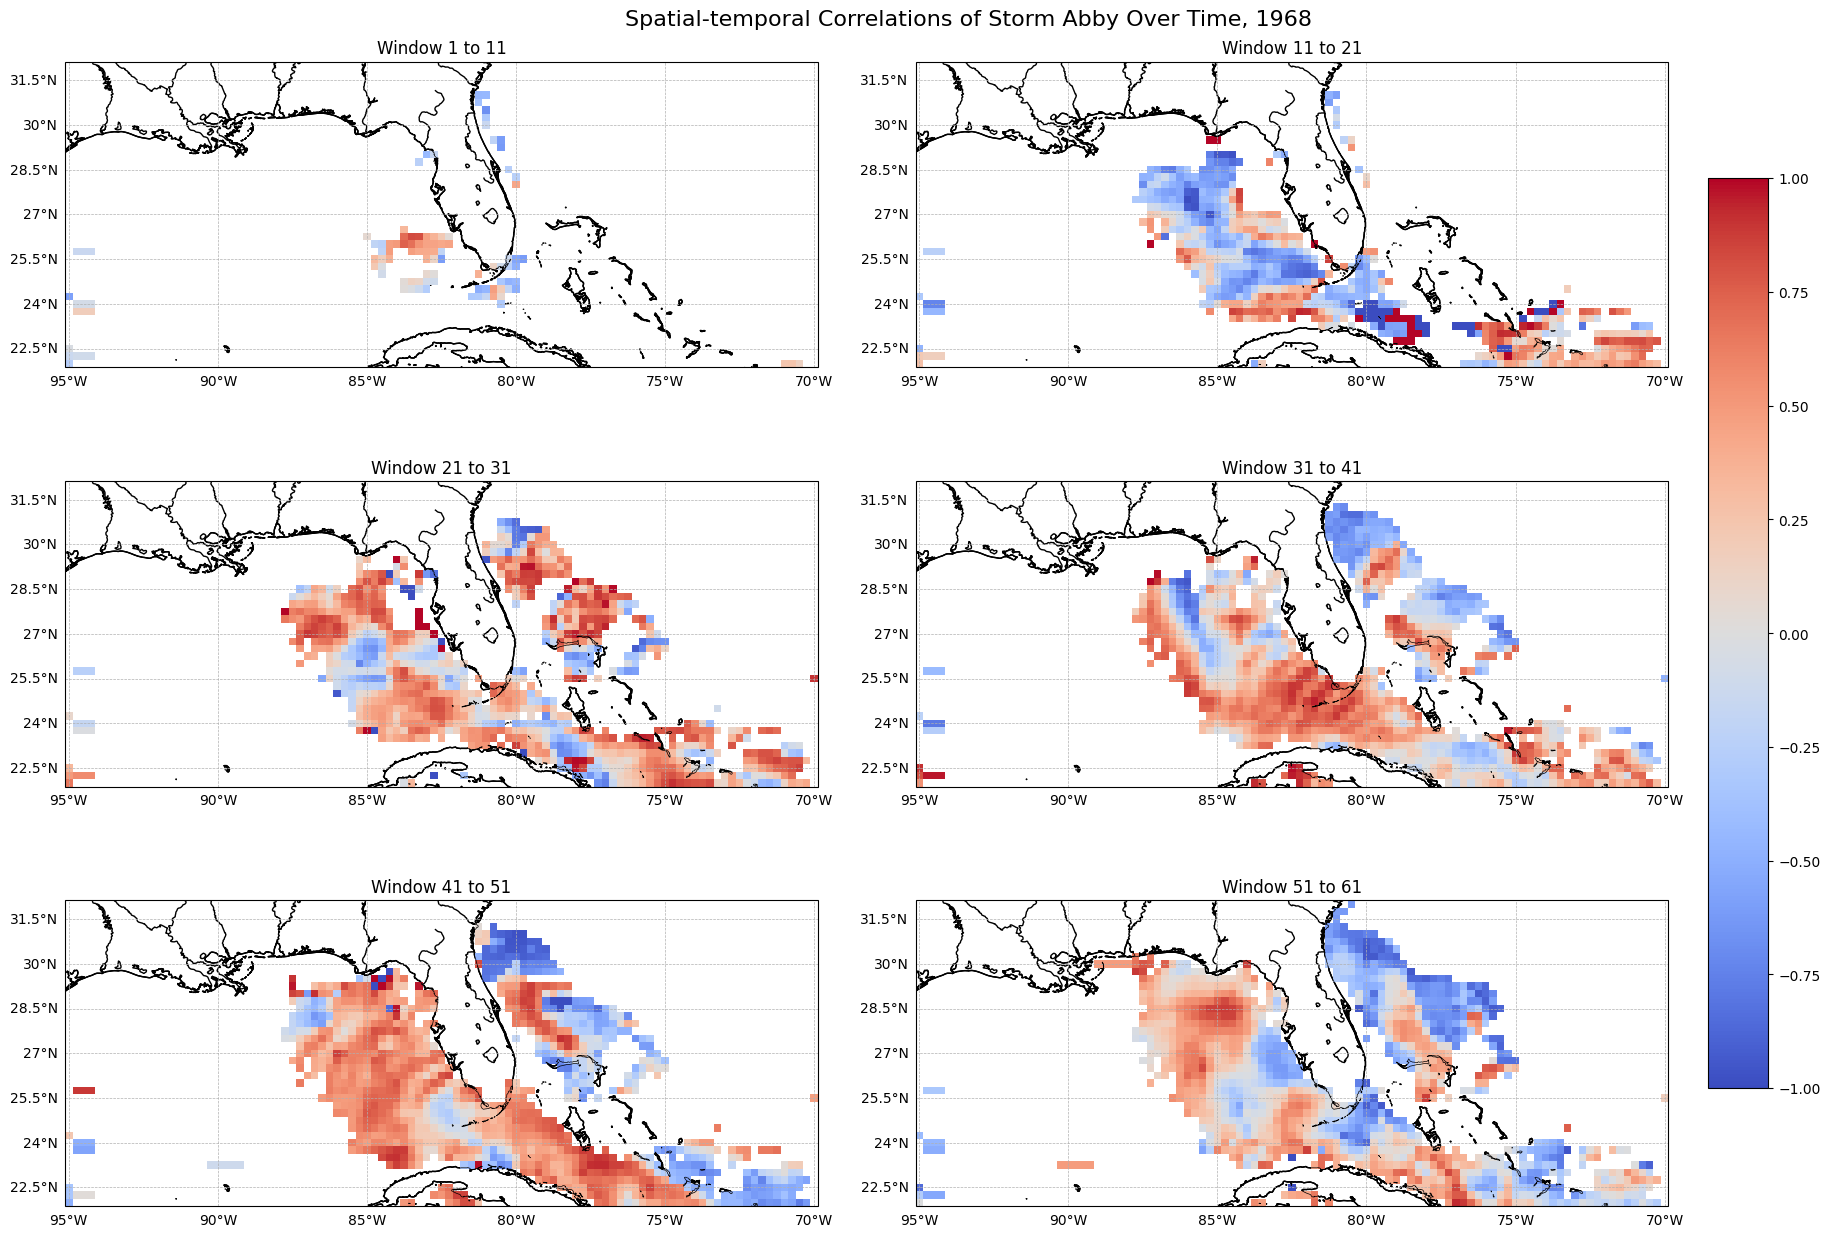

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import xarray as xr

# Function to create a grid of correlation plots
def plot_correlation_grid(ds, start_frame, title, output_file):
    # Setup the plot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 13), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()  # Flatten the 2D axes array to 1D for easier iteration
    
    window_size = 10  # Define the size of the time window
    
    for i, ax in enumerate(axes):
        current_frame = start_frame + i * window_size  # Adjust index for non-overlapping windows
        time_window = ds.isel(time=slice(current_frame, current_frame + window_size))
        correlations = xr.corr(time_window['ws10'], time_window['tp'], dim='time')
        
        # Plot correlation
        im = correlations.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='coolwarm', vmin=-1, vmax=1)
        
        # Add map features
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.RIVERS, edgecolor='black')
        
        # Set gridlines and labels
        gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        
        # Set titles and labels
        ax.set_title(f'Window {current_frame} to {current_frame + window_size}', fontsize=12)
        ax.set_xlabel('Longitude', fontsize=10)
        ax.set_ylabel('Latitude', fontsize=10)
    
    # Adjust layout and add a colorbar
    plt.tight_layout(pad=3)
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-1, vmax=1)), cax=cbar_ax)
    
    plt.suptitle(title, fontsize=16)
    plt.savefig(output_file)
    plt.show()

# Example usage
plot_correlation_grid(ds_filtered_temporal, 1, 'Spatial-temporal Correlations of Storm Abby Over Time, 1968', 'correlation_grid.png')


In [13]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.animation as animation

def get_threshold(data_array, quantile=0.95):
    return np.percentile(data_array, quantile * 100)

def filter_data(file_path, quantile=0.95):
    ds = xr.open_dataset(file_path)

    tp_threshold = get_threshold(ds['tp'], quantile)
    ws10_threshold = get_threshold(ds['ws10'], quantile)

    tp_mask = ds['tp'] >= tp_threshold
    ws10_mask = ds['ws10'] >= ws10_threshold

    location_mask = (tp_mask & ws10_mask).any(dim='time')
    ds_filtered_spatial = ds.where(location_mask, drop=True)

    def filter_temporal(data_array, combined_mask):
        time_dim, lat_dim, lon_dim = data_array.dims

        time_mask = np.zeros(combined_mask.shape, dtype=bool)

        for lat in range(combined_mask.shape[1]):
            for lon in range(combined_mask.shape[2]):
                mask = combined_mask[:, lat, lon]
                if mask.any():
                    first_idx = mask.argmax().item()
                    last_idx = len(mask) - mask[::-1].argmax().item()
                    time_mask[first_idx:last_idx, lat, lon] = True

        temporal_mask = xr.DataArray(time_mask, dims=[time_dim, lat_dim, lon_dim], coords=data_array.coords)
        return data_array.where(temporal_mask, drop=True)

    combined_mask_tp = tp_mask.sel(latitude=ds_filtered_spatial.latitude, longitude=ds_filtered_spatial.longitude)
    combined_mask_ws10 = ws10_mask.sel(latitude=ds_filtered_spatial.latitude, longitude=ds_filtered_spatial.longitude)

    tp_filtered_temporal = filter_temporal(ds_filtered_spatial['tp'], combined_mask_tp | combined_mask_ws10)
    ws10_filtered_temporal = filter_temporal(ds_filtered_spatial['ws10'], combined_mask_tp | combined_mask_ws10)

    ds_filtered_temporal = xr.Dataset({
        'tp': tp_filtered_temporal,
        'ws10': ws10_filtered_temporal
    })

    return ds_filtered_temporal

def process_folder(input_folder, output_folder, quantile=0.95):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith('.nc'):
            file_path = os.path.join(input_folder, filename)
            ds_filtered = filter_data(file_path, quantile)
            output_path = os.path.join(output_folder, filename)
            ds_filtered.to_netcdf(output_path)
            print(f'Processed {filename} and saved to {output_path}')

In [14]:
def calculate_spatial_correlation(ds):
    tp = ds['tp']
    ws10 = ds['ws']
    
    correlation = xr.corr(tp, ws10, dim='time')
    return correlation

def plot_spatial_correlation(ds, title='Spatial Correlation between Total Precipitation and 10 Metre Wind Speed'):
    spatial_correlation = calculate_spatial_correlation(ds)
    
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    im = spatial_correlation.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=-1, vmax=1, 
        cbar_kwargs={'label': 'Correlation coefficient', 'shrink': 0.5})
    # Add map features without colors
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    plt.title(title, fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    # fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-1, vmax=1)), ax=ax, orientation='horizontal', pad=0.05, fraction=0.05)
    plt.show()

In [15]:
def animate_correlations(ds, title, output_file):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    window_size = 10  # Define the size of the time window

    def update(frame):
        ax.clear()
        time_window = ds.isel(time=slice(frame, frame + window_size))
        correlations = xr.corr(time_window['ws'], time_window['tp'], dim='time')
        
        im = correlations.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='coolwarm', vmin=-1, vmax=1)

        
        # Add map features without colors
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
        ax.add_feature(cfeature.RIVERS, edgecolor='black')

        gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        
        ax.set_title(f'Correlation between ws10 and tp for time window {frame} to {frame + window_size}\n{title}', fontsize=16)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        
        return im
    
    ani = animation.FuncAnimation(fig, update, frames=range(len(ds['time']) - window_size), repeat=False)
    fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-1, vmax=1)), ax=ax, pad=0.05, fraction=0.01)
    ani.save(output_file, writer='imagemagick', fps=2)
    plt.show()

In [63]:
# input_folder = 'ws_tp_only_nc'
# output_folder = '95_ws_tp_only_nc_continuos'
# quantile = 0.95

# process_folder(input_folder, output_folder, quantile)

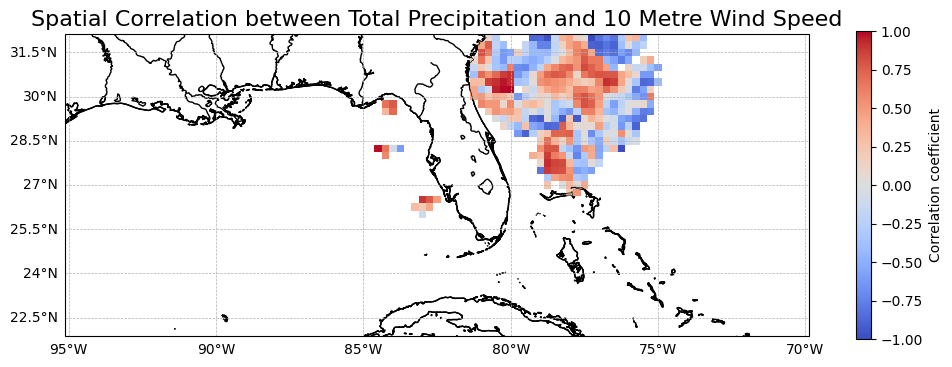

Python(32952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
MovieWriter imagemagick unavailable; using Pillow instead.


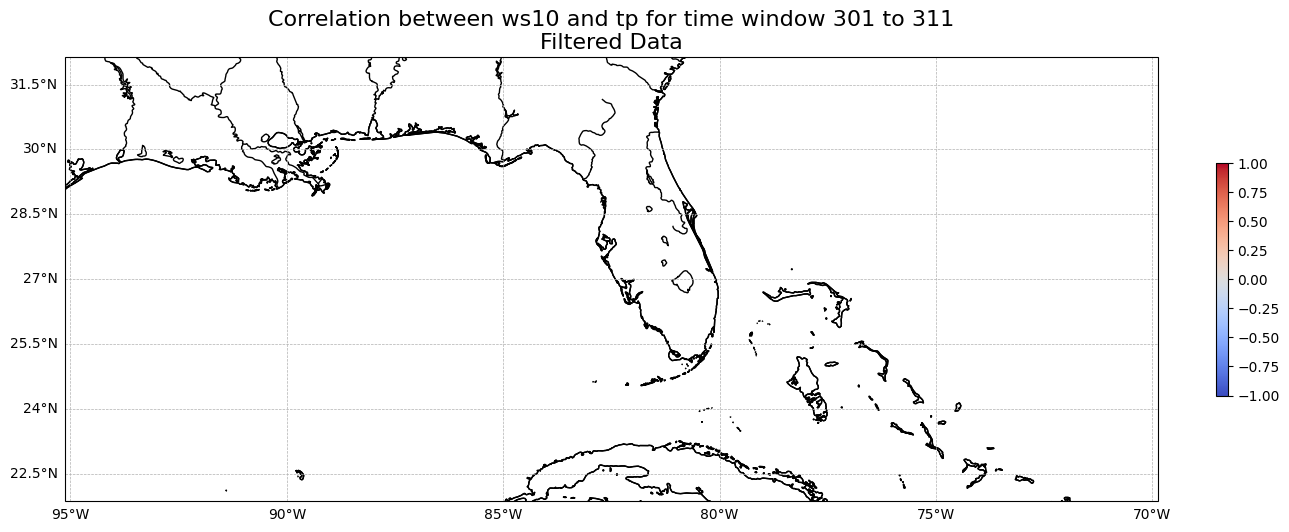

In [77]:
# Example to visualize one of the processed files
example_file = os.path.join('/Users/xinyuhu/Desktop', 'ABBY_remove.nc')
ds_filtered = xr.open_dataset(example_file)

plot_spatial_correlation(ds_filtered)
animate_correlations(ds_filtered, 'Filtered Data', 'temporal_correlation1.gif')